# Model selection

Cross-validation is used here to select the best model. In this script it is used to test the best machine learning model for use in this context.

<u>Tests using the following models :</u>
* Linear regression
* Random forest regressor
* XGBoost
* Extra Trees Regressor

<u> The following variables are included in the model:</u>
* Weather variables (rain, temperature, windspeed)
* Time variables (Day of week, month, year, time of day, public holiday)
* Sensor environment variables (within a 500m buffer of the sensor):
    * Betweenness of the street 
    * Buildings in proximity to the sensor
    * Landmarks in proximity to the sensor  
    * Furniture in proximity to the sensor    
    * Lights in proximity to the sensor   

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
import xgboost as xgb
from sklearn.pipeline import Pipeline
import folium
import branca.colormap as cm
from eli5.sklearn import PermutationImportance
import joblib
import os
import psutil
import geopy.distance
from sklearn.model_selection import TimeSeriesSplit

from Functions import *

#https://goldinlocks.github.io/Time-Series-Cross-Validation/ 
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [2]:
buffer_size_m = 400
input_csv ="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)

## Run models with cross-validation

### Define the error metrics for the cross-validation to return, and the parameters of the cross validation

In [3]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
cv_parameters = KFold(n_splits=10, random_state=1, shuffle=True)
cv_parameters = btscv = BlockingTimeSeriesSplit(n_splits=10)

In [4]:
lr_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['linear_regressor',LinearRegression()]])
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor', RandomForestRegressor(random_state = 1, n_jobs = 10)]])
xgb_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['xgb_regressor',xgb.XGBRegressor(random_state=1, n_jobs = 16)]])
et_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['et_regressor',ExtraTreesRegressor (random_state = 1, n_jobs = 16)]])

In [5]:
models_dict = {"rf_regressor":rf_model_pipeline,
               "linear_regressor": lr_model_pipeline, "xgb_regressor":xgb_model_pipeline
              }

### Prepare data for modelling

In [6]:
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)

### Remove year

In [7]:
# del Xfull['year']

### Choose which month_num and weekday_num option to include

In [8]:
# If using the dummy variables
# Xfull.drop(['Cos_month_num', 'Sin_month_num', 'Cos_weekday_num', 'Sin_weekday_num'], axis=1)
# If using the cyclical variables
Xfull.drop(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'], axis=1, inplace = True)

In [9]:
Xfull.columns

Index(['year', 'Temp', 'Humidity', 'Pressure', 'Rain', 'WindSpeed',
       'Rainfall amount (millimetres)', 'public_holiday', 'school_holiday',
       'betweenness', 'lights', 'memorials', 'trees', 'transport_stops',
       'bus-stops', 'tram-stops', 'metro-stations', 'taxi-ranks',
       'big-car-parks', 'street_inf_Bicycle Rails', 'street_inf_Bollard',
       'street_inf_Drinking Fountain', 'street_inf_Floral Crate/Planter Box',
       'street_inf_Horse Trough', 'street_inf_Information Pillar',
       'street_inf_Litter Bin', 'street_inf_Seat', 'street_inf_Tree Guard',
       'landmarks_Community Use', 'landmarks_Mixed Use',
       'landmarks_Place Of Assembly', 'landmarks_Place of Worship',
       'landmarks_Retail', 'landmarks_Transport', 'landmarks_Education Centre',
       'landmarks_Office', 'street_inf_Hoop', 'street_inf_Picnic Setting',
       'landmarks_Leisure/Recreation', 'street_inf_Barbeque',
       'landmarks_Specialist Residential Accommodation',
       'landmarks_Vacan

### Run model with cross validation

In [62]:
models_dict = {"rf_regressor":rf_model_pipeline,}

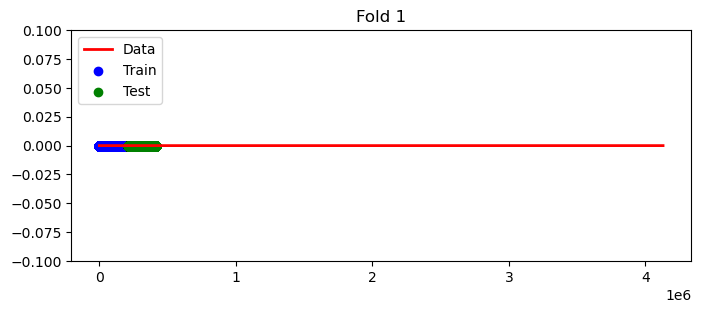

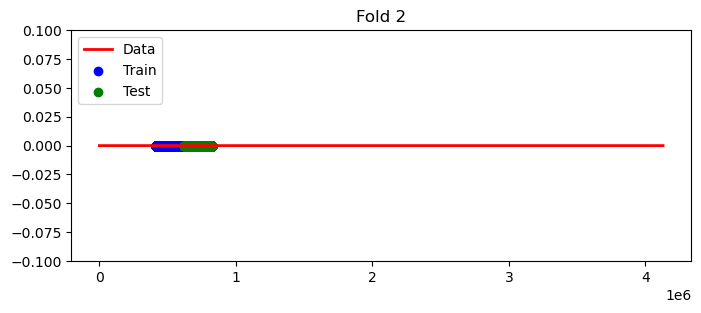

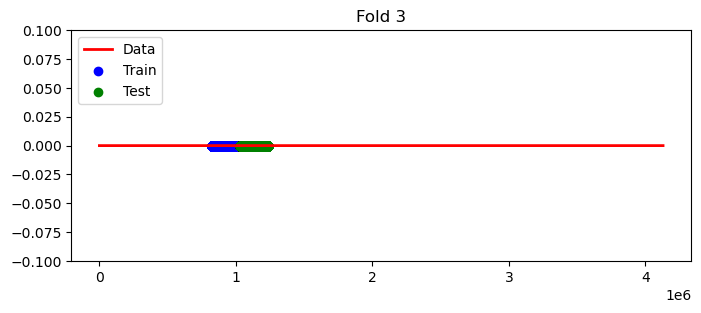

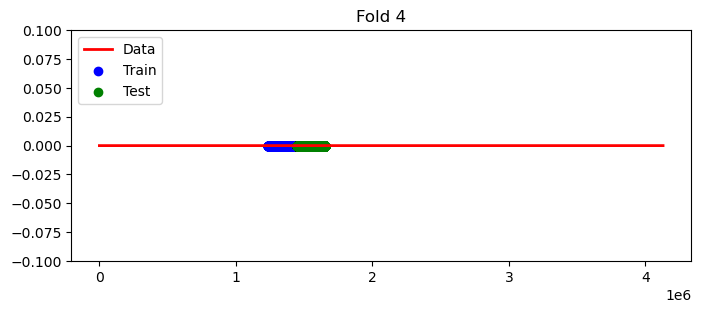

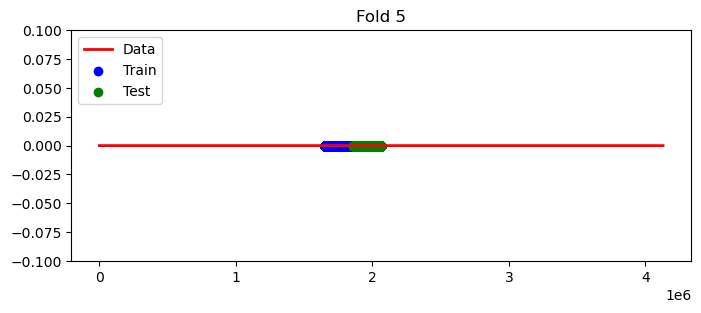

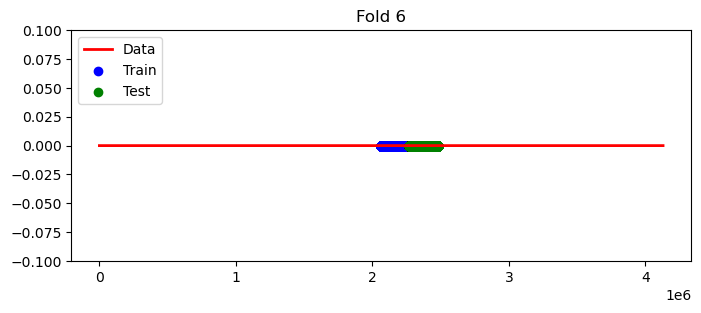

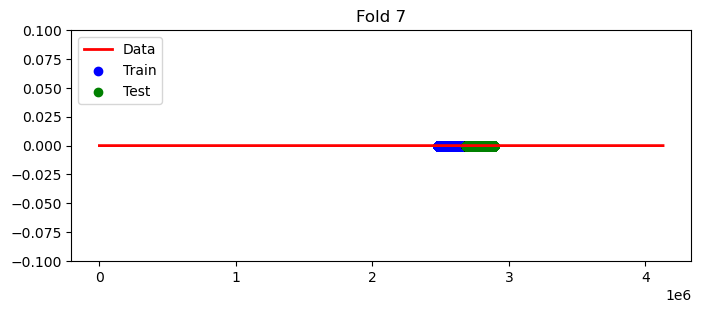

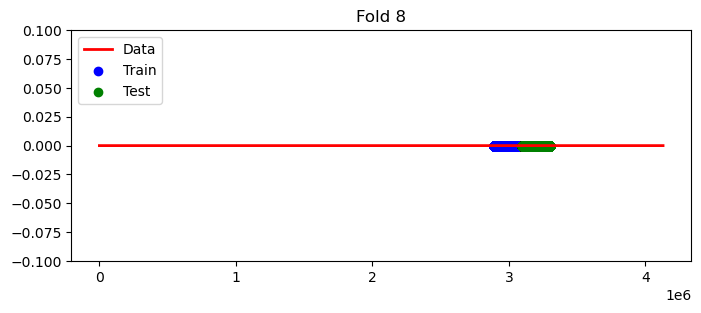

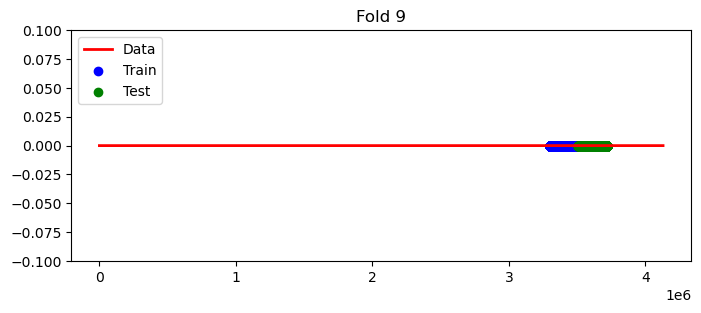

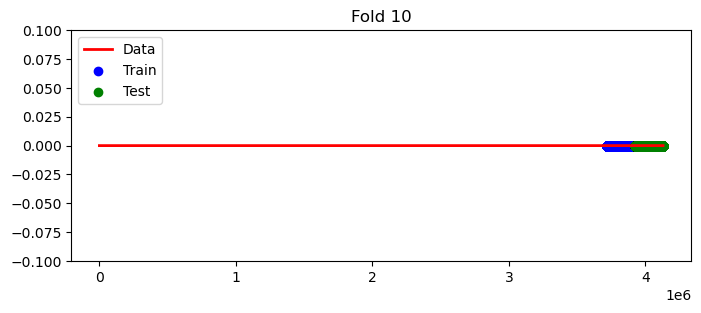

In [67]:
data = Yfull
for fold, (train_index, test_index) in enumerate(cv_parameters.split(data)):
    # Plot the fold indices
    plt.figure(figsize=(8, 3))
    plt.plot(np.arange(len(data)), np.zeros_like(data), 'r-', lw=2, label='Data')
    plt.scatter(train_index, np.zeros_like(train_index), c='b', marker='o', label='Train')
    plt.scatter(test_index, np.zeros_like(test_index), c='g', marker='o', label='Test')
    plt.title(f'Fold {fold+1}')
    plt.legend(loc='upper left')
    plt.ylim(-0.1, 0.1)
    plt.show()

In [64]:
cv_parameters = BlockingTimeSeriesSplit(n_splits=10)
# cv_parameters =  KFold(n_splits=10, random_state=1, shuffle=True)
# cv_parameters = TimeSeriesSplit(n_splits=10)

In [72]:
# Create the BlockedTimeSeriesSplit object
btss = BlockingTimeSeriesSplit(n_splits=3)
# Perform cross-validation with spatial and temporal blocking
for train_temporal_index, test_temporal_index in btss.split(X):
    print(train_temporal_index, test_temporal_index)

[     0      1      2 ... 688177 688178 688179] [ 688180  688181  688182 ... 1376357 1376358 1376359]
[1376360 1376361 1376362 ... 2064537 2064538 2064539] [2064540 2064541 2064542 ... 2752717 2752718 2752719]
[2752720 2752721 2752722 ... 3440897 3440898 3440899] [3440900 3440901 3440902 ... 4129077 4129078 4129079]


In [65]:
# Dataframe to store the scores for all the models
#error_metric_scores = pd.DataFrame()

for model_name, model_pipeline in models_dict.items():
    print(model_name)
    # Use cross_validate to return the error scores associated with this model and this data
    start = time()
    model_output = cross_validate(model_pipeline, Xfull, Yfull, cv=cv_parameters, scoring=error_metrics, error_score="raise")
    end = time()
    print('Ran in {} minutes'.format(round((end - start)/60),2))
    
    # Formulate the different error scores into a dataframe
    error_metrics_df =pd.DataFrame({'mae': round(abs(model_output['test_neg_mean_absolute_error'].mean()),2), 
                  'mape': round(abs(model_output['test_neg_mean_absolute_percentage_error'].mean()),2),
                  'r2': round(abs(model_output['test_r2'].mean()),2), 
                  'rmse': round(abs(model_output['test_neg_root_mean_squared_error'].mean()),2)},
                 index =[model_name])
        
    # Add evaluation metric scores for this model to the dataframe containing the metrics for each model
    error_metric_scores = error_metric_scores.append(error_metrics_df)
    # Save error scores for this distance to file
    error_metrics_df.to_csv('Results/CV/ComparingModels/{}_{}m_error_metric_scores.csv'.format(model_name,buffer_size_m),index=False)    

# Save dataframes of error metrics for each buffer distance 
error_metric_scores.to_csv('Results/CV/ComparingModels/comparingmodels_error_metric_scores.csv')   

rf_regressor
Ran in 4 minutes


### Print table showing error metrics associated with each model

In [68]:
error_metric_scores

,mae,mape,r2,rmse
rf_regressor,100.29,2.631653e+15,0.75,199.69
rf_regressor,100.29,2.631653e+15,0.75,199.69
rf_regressor,100.29,2.631653e+15,0.75,199.69
rf_regressor,100.29,2.631653e+15,0.75,199.69
rf_regressor,58.35,1.438735e+15,0.94,120.87
rf_regressor,100.29,2.631653e+15,0.75,199.69
